Интересно, что тема урока называется Урок 3. Коллаборативная фильтрация. За весь урок и в методичках ни разу не упомянут  этот термин. Что же это такое? :)

## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи?   
Если есть функция item_item_rec(interaction_matrix).   
Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


#### Ответ:
1. User-User ищет близкие вектора по векторам user, Item-Item по векторам item. Соответсвенно находят первые близких пользователей, а вторые близкие товары.  Похожи тем, что используют одну и туже матрицу (транспонированную в одном случае) и способ поиска k ближайших соседей.  
2. Да, нужно траспонировать матрицу  
3. item-item использует k ближайших соседей, потом ищет 'рейтинг" товара. ALS обучается используя градиентный спуск, минимизируя функцию потерь создавая две матрицы UxK и  KxI, что бы потом их перемножить и получить предсказания по всей матрице.  


2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


#### Ответ
цена  
рентабельность продаж  
маржа  
срок годности  




3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)



#### Ответ  
ALS учитывает только линейные зависимотси

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

#### Ответ
По мне так очень похож на tfidf.
https://habr.com/ru/post/162937/

## Практическая часть


In [1]:
import implicit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
# Для работы с матрицами
from scipy.sparse import csr_matrix
import pickle
# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [2]:

def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    
    return precision




 

def get_recommendations_all(model,N=5):
    result = model.recommend_all(user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)
    result = pd.DataFrame(result)
    result.index = result.index.map(id_to_userid)
    for i in result.columns[:5]:
        result.loc[:,i] = result.loc[:,i].map(id_to_itemid)
    result['result'] = result.apply(lambda row: [row[i] for i in range(5)],axis=1)
    
    return result


### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [3]:
score=pd.DataFrame()

In [4]:
data = pd.read_csv('../data/retail_train.csv')
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result['train'] = result['user_id'].map(data_train.groupby('user_id')['item_id'].unique())
result.rename(columns={'item_id':'actual'},inplace=True)
result.head(2)

,user_id,actual,train
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[825123, 831447, 840361, 845307, 852014, 85498..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[866211, 878996, 882830, 904360, 921345, 93194..."


In [6]:
popularity = data_train.groupby('item_id')['quantity'].count().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

C:\Users\lqw\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [7]:
data_train['score'] = 1

data_train.loc[data_train.day>=(max(data_train.day) - 60),'score'] =2


<ipython-input-7-08debe943af4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['score'] = 1
C:\Users\lqw\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Посчитаем различные варианты 

In [8]:
%%time
model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=-1) 

for i in [('quantity','count'),('quantity','sum'),('sales_value','sum'),('score','sum')]:

    user_item_matrix = pd.pivot_table(data_train, 
                              index='user_id', columns='item_id', 
                              values=i[0], # Можно пробоват ьдругие варианты
                              aggfunc=i[1], 
                              fill_value=0
                             )
        
    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

    # переведем в формат saprse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()
    csr_mat = csr_matrix(user_item_matrix.T).tocsr()
    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids)) 
    
    

    model.fit(csr_mat,  # На вход item-user matrix
          show_progress=False)
    
    rec_all = get_recommendations_all(model,N=5)
    result[f'{i[0]}_{i[1]}'] = result['user_id'].map(rec_all['result'])
    score.loc[f'{i[0]}_{i[1]}' ,'test']= result.apply(lambda row: precision_at_k(row[f'{i[0]}_{i[1]}'], row['actual']), axis=1).mean()
    score.loc[f'{i[0]}_{i[1]}' ,'train']= result.apply(lambda row: precision_at_k(row[f'{i[0]}_{i[1]}'], row['train']), axis=1).mean()
    
   
    item_user_matrix_tfidf = tfidf_weight(csr_mat)
    model.fit(item_user_matrix_tfidf,  # На вход item-user matrix
          show_progress=False)
    rec_all = get_recommendations_all(model,N=5)
    result[f'{i[0]}_{i[1]}_tf'] = result['user_id'].map(rec_all['result'])
    score.loc[f'{i[0]}_{i[1]}_tf' ,'test']= result.apply(lambda row: precision_at_k(row[f'{i[0]}_{i[1]}_tf'], row['actual']), axis=1).mean()
    score.loc[f'{i[0]}_{i[1]}_tf' ,'train']= result.apply(lambda row: precision_at_k(row[f'{i[0]}_{i[1]}_tf'], row['train']), axis=1).mean()
        
    item_user_matrix_bm_25 = bm25_weight(csr_mat)
    
    model.fit(item_user_matrix_bm_25,  # На вход item-user matrix
          show_progress=False)
    rec_all = get_recommendations_all(model,N=5)
    result[f'{i[0]}_{i[1]}_bm25'] = result['user_id'].map(rec_all['result'])
    score.loc[f'{i[0]}_{i[1]}_bm25' ,'test']= result.apply(lambda row: precision_at_k(row[f'{i[0]}_{i[1]}_bm25'], row['actual']), axis=1).mean()
    score.loc[f'{i[0]}_{i[1]}_bm25' ,'train']= result.apply(lambda row: precision_at_k(row[f'{i[0]}_{i[1]}_bm25'], row['train']), axis=1).mean()    


Wall time: 5min 45s


In [9]:
score.sort_values(by='test',ascending=False)

,test,train
quantity_count_bm25,0.229971,0.840940
score_sum_bm25,0.229481,0.841528
quantity_sum_bm25,0.188737,0.677571
quantity_count_tf,0.187953,0.800588
score_sum_tf,0.182566,0.786484
quantity_count,0.181783,0.871499
score_sum,0.170029,0.832713
quantity_sum_tf,0.166405,0.801959
quantity_sum,0.155926,0.820372
sales_value_sum_bm25,0.134084,0.658962


Очевидно, что лучше считать количесвто покупок. bm25 - лучше перевзвешивает матрицу во всех случаях

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [10]:
user_item_matrix = pd.pivot_table(data_train, 
                              index='user_id', columns='item_id', 
                              values='quantity', # Можно пробоват ьдругие варианты
                              aggfunc='count', 
                              fill_value=0
                             )
        
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()
csr_mat = csr_matrix(user_item_matrix.T).tocsr()
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids)) 
    
item_user_matrix_bm_25 = bm25_weight(csr_mat)    

In [11]:
%%time
params = pd.DataFrame()
i = 1
for factor in [800,950,1100]:
    for regularization in [35,37,40]:
        for iterations in [15,20,30]:
            start = time.time()
            model = AlternatingLeastSquares(factors=factor, 
                                        regularization=regularization,
                                        iterations=iterations, 
                                        calculate_training_loss=False, 
                                        num_threads=-1) 

            model.fit(item_user_matrix_bm_25,show_progress=False)

            params.loc[i,'factor'] = factor
            params.loc[i,'regularization'] = regularization
            params.loc[i,'iterations'] = iterations
            rec_all = get_recommendations_all(model,N=5)
            result[i] = result['user_id'].map(rec_all['result'])
            params.loc[i,'score_test'] = result.apply(lambda row: precision_at_k(row[i], row['actual']), axis=1).mean()
            finish = time.time()
            params.loc[i,'time_minuts'] = (finish-start)/60
            i+=1


Wall time: 10h 4min 36s


In [12]:
params.sort_values(by='score_test',ascending=False).head(15)

,factor,regularization,iterations,score_test,time_minuts
20,1100.0,35.0,20.0,0.343879,30.034507
21,1100.0,35.0,30.0,0.343781,30.282433
12,950.0,35.0,30.0,0.343781,21.741074
19,1100.0,35.0,15.0,0.343683,30.165793
10,950.0,35.0,15.0,0.343487,21.832758
23,1100.0,37.0,20.0,0.342801,29.993703
11,950.0,35.0,20.0,0.342703,21.649174
5,800.0,37.0,20.0,0.342703,15.529933
24,1100.0,37.0,30.0,0.342311,30.067036
22,1100.0,37.0,15.0,0.342311,30.100834


In [13]:
factor = np.sort(params.factor.unique())
regularization = np.sort(params.regularization.unique())
iterations = np.sort(params.iterations.unique())

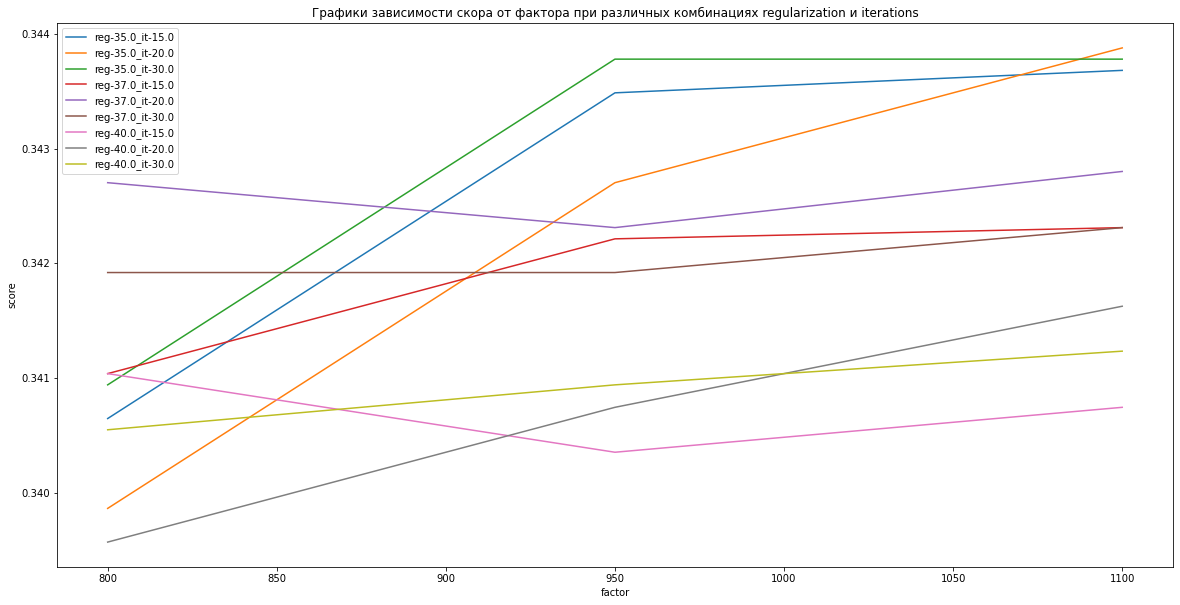

In [14]:
plt.figure(figsize=(20,10) )


for i in regularization:
    for j in iterations:
        my_plot = params.loc[(params.regularization ==i)&(params.iterations ==j)]
        plt.plot(my_plot.factor,my_plot.score_test,  label=f'reg-{i}_it-{j}')
plt.legend()        
plt.xlabel('factor')
plt.ylabel('score')
plt.title('Графики зависимости скора от фактора при различных комбинациях regularization и iterations')

plt.show()  

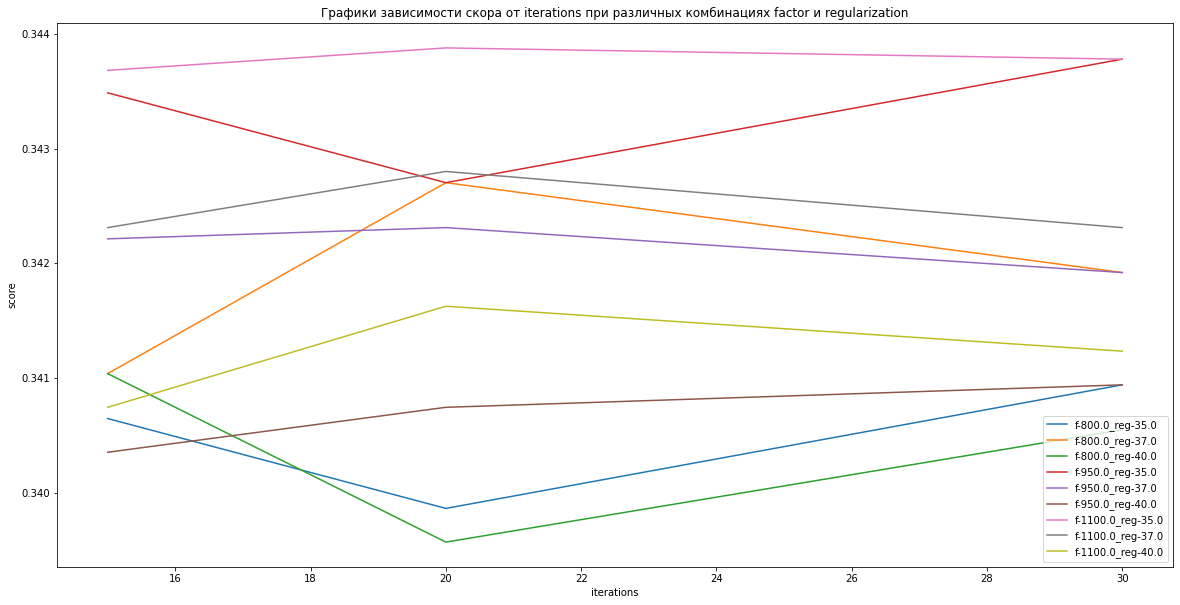

In [15]:
plt.figure(figsize=(20,10) )


for i in factor:
    for j in regularization: 
        my_plot = params.loc[(params.factor ==i)&(params.regularization ==j)]
        plt.plot(my_plot.iterations,my_plot.score_test,label=f'f-{i}_reg-{j}')
plt.legend()        
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('Графики зависимости скора от iterations при различных комбинациях factor и regularization')

plt.show()   

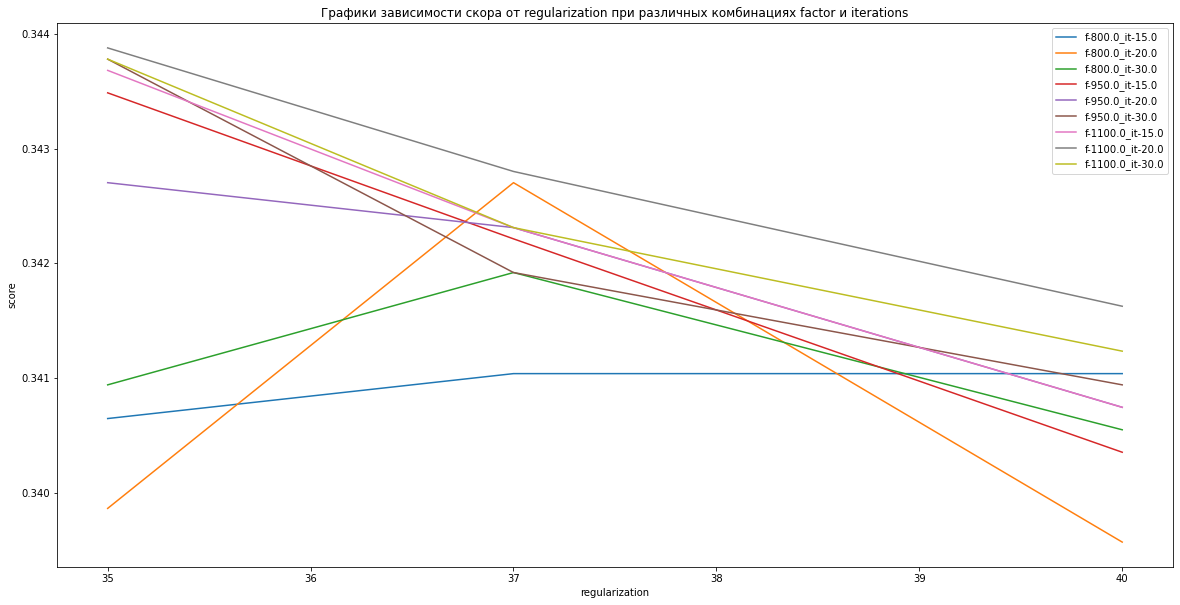

In [16]:
plt.figure(figsize=(20,10) )


for i in factor:
    for j in iterations: 
        my_plot = params.loc[(params.factor ==i)&(params.iterations ==j)]
        plt.plot(my_plot.regularization,my_plot.score_test,label=f'f-{i}_it-{j}')
plt.legend()        
plt.xlabel('regularization')
plt.ylabel('score')
plt.title('Графики зависимости скора от regularization при различных комбинациях factor и iterations')

plt.show()   

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!